In [1]:
import numpy as np
import pandas as pd
import dill
import matplotlib.pyplot as plt

%matplotlib inline
from flask import Flask,Blueprint,request,render_template,jsonify
from sklearn.feature_extraction.text import TfidfVectorizer
#from modules.dataBase import collection as db

#pipeline
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from catboost import CatBoostClassifier


from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve
from sklearn.metrics import f1_score

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold
%matplotlib inline

import itertools



In [2]:
df = pd.read_csv("emails.csv")
df.head(3)

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1


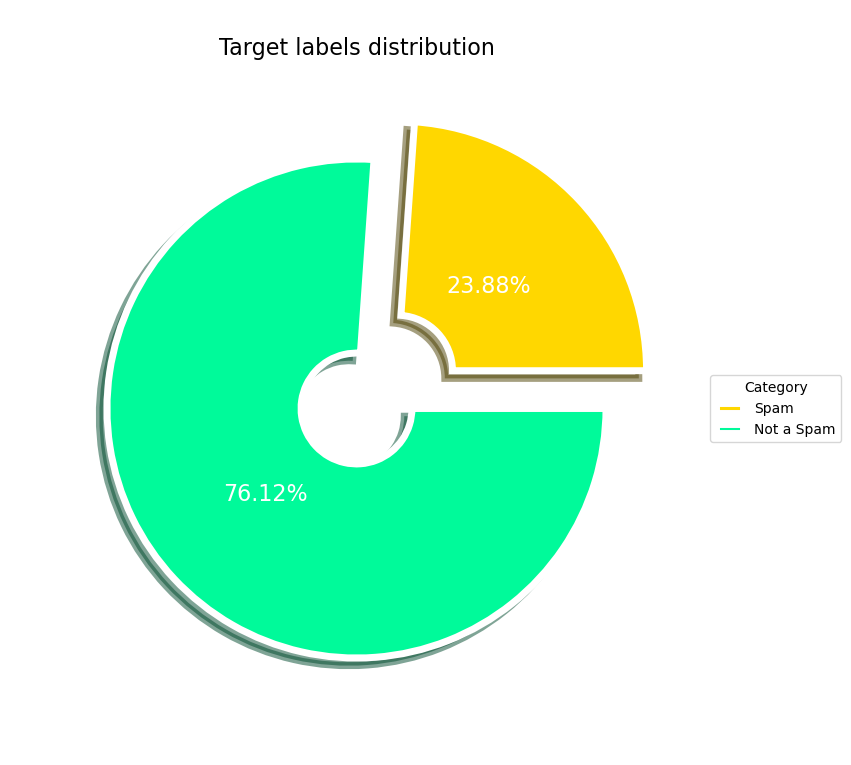

In [3]:
plt.subplots(figsize=(9, 9))

labels = "Spam","Not a Spam"
size = 0.7

wedges, texts, autotexts = plt.pie([len(df[df["spam"]==1]["spam"]),
                                    len(df[df["spam"]==0]["spam"])],
                                    explode = (0.2,0),
                                    textprops=dict(size= 16, color= "white"), # размер и цвет текста внутри диаграмы
                                    autopct="%.2f%%",
                                    pctdistance = 0.5, # положение текста значение процентов
                                    radius=0.9, 
                                    shadow = True, # добовляет эфект тени к диаграме
                                    wedgeprops=dict(width = size, edgecolor = "white", 
                                    linewidth = 5), # круг добовляет в центре
                                    startangle = 0, colors= ['gold', 'mediumspringgreen'])

plt.legend(wedges, labels, title="Category",loc="center left",bbox_to_anchor=(1, 0, 0.5, 1))
plt.title("\nTarget labels distribution",fontsize=16)
plt.show()

### Разделение на тест и трейн 

In [4]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['spam']), df['spam'], test_size=0.33, random_state=42, stratify=df['spam'])
# save test
X_test.to_csv("X_test.csv", index=None)
y_test.to_csv("y_test.csv", index=None)

# save train
X_train.to_csv("X_train.csv", index=None)
y_train.to_csv("y_train.csv", index=None)

In [5]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]


class TextImputer(BaseEstimator, TransformerMixin):
    def __init__(self, key, value):
        self.key = key
        self.value = value

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X[self.key] = X[self.key].fillna(self.value)
        return X

In [6]:
text = Pipeline([
                ('imputer', TextImputer('text', '')),
                ('selector', ColumnSelector(key='text')),
                ('tfidf', TfidfVectorizer(stop_words='english', use_idf=True,
                lowercase=True,
                smooth_idf=True))
            ])

In [7]:
pipeline = Pipeline([
    ('features', text),
    ('classifier', CatBoostClassifier(silent=True, random_state=23, n_estimators= 1540, max_depth=5)),
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 Pipeline(steps=[('imputer', TextImputer(key='text', value='')),
                                 ('selector', ColumnSelector(key='text')),
                                 ('tfidf',
                                  TfidfVectorizer(stop_words='english'))])),
                ('classifier',
                 <catboost.core.CatBoostClassifier object at 0x00000148687227D0>)])

### Сохранение и выгрузка

In [8]:
with open("pipeline.dill", "wb") as f:
    dill.dump(pipeline, f)

In [9]:
X_test = pd.read_csv("X_test.csv")
y_test = pd.read_csv("y_test.csv")

In [10]:
with open('pipeline.dill', 'rb') as in_strm:
    pipeline = dill.load(in_strm)

### Предсказание и метрики

In [11]:
preds = pipeline.predict_proba(X_test)[:, 1]

pred_df = pd.DataFrame({'preds': preds})
pred_df.to_csv("test_predictions.csv", index=None)

In [12]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.4954694902329087, F-Score=0.959, Precision=0.964, Recall=0.954


In [13]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1423   16]
 [  21  431]]


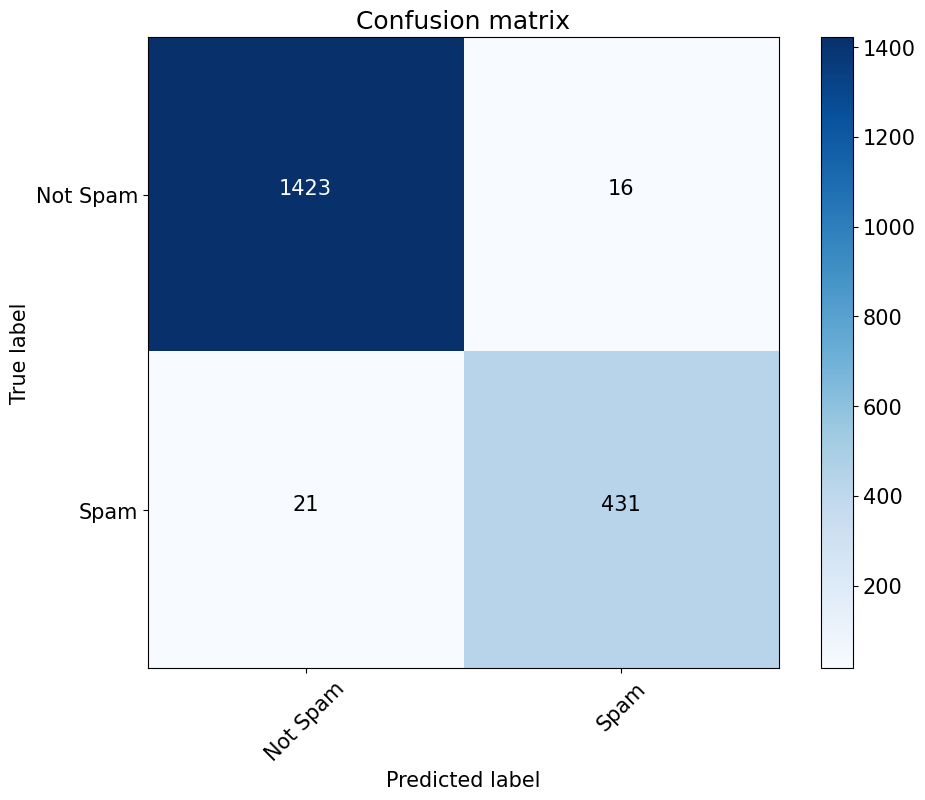

In [14]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds >= thresholds[ix])
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Not Spam', 'Spam'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

### Запуск сервера на Flask

In [25]:
# Обработчики и запуск Flask
app = Flask(__name__)

@app.route("/", methods=["GET"])
def general():
    return "Welcome to prediction process"

@app.route('/predict', methods=['POST'])
def predict():
    data = {"success": False}
    # ensure an impipeline
    request_json = request.get_json()

    if request_json["text"]:
        text = request_json['text']
        
    
    df_for_pred = pd.DataFrame({"text": [str(text)]})
    print(df_for_pred)
    preds = pipeline.predict_proba(df_for_pred)
    print(preds[:, 1])
    data["predictions"] = preds[:, 1][0]
    data["text"] = text
        # indicate that the request was a success
    data["success"] = True
    print('OK')


        # return the data dictionary as a JSON response
    return jsonify(data)

if __name__ == '__main__':
    app.run(debug=False, port=5000)

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit


                                                text
0  naturally irresistible your corporate identity...


127.0.0.1 - - [21/Sep/2023 10:45:09] "POST /predict HTTP/1.1" 200 -


[0.98490944]
OK


127.0.0.1 - - [21/Sep/2023 10:47:12] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [21/Sep/2023 10:47:12] "POST /predict HTTP/1.1" 200 -


                                                text
0  naturally irresistible your corporate identity...
[0.98490944]
OK
                                                text
0  naturally irresistible your corporate identity...
[0.98490944]
OK


127.0.0.1 - - [21/Sep/2023 10:50:33] "POST /predict HTTP/1.1" 200 -


                                                text
0  the stock trading gunslinger  fanny is merrill...
[0.79551989]
OK
                                                text
0  the stock trading gunslinger  fanny is merrill...
[0.79551989]
OK


127.0.0.1 - - [21/Sep/2023 10:50:33] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [21/Sep/2023 10:50:49] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [21/Sep/2023 10:50:49] "POST /predict HTTP/1.1" 200 -


                                                text
0  the stock trading gunslinger  fanny is merrill...
[0.79551989]
OK
                                                text
0  the stock trading gunslinger  fanny is merrill...
[0.79551989]
OK


127.0.0.1 - - [21/Sep/2023 10:50:57] "POST /predict HTTP/1.1" 200 -


                                                text
0  the stock trading gunslinger  fanny is merrill...
[0.79551989]
OK


127.0.0.1 - - [21/Sep/2023 10:51:14] "POST /predict HTTP/1.1" 200 -


  text
0   Hi
[0.36612622]
OK


127.0.0.1 - - [21/Sep/2023 10:51:24] "POST /predict HTTP/1.1" 200 -


  text
0   Hi
[0.36612622]
OK
